In [1]:
if True:
    import numpy as np
    import pandas as pd
    from scipy.optimize import curve_fit

    # Add lab library
    import sys
    sys.path.insert(0, '/home/trevormjs/Documents/Science/APL/Lab')

    #---------------------------------------------------------------------#
    #                        matplotlib plotting                          #
    #---------------------------------------------------------------------#
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from jupyterthemes import jtplot
    from Helper.plotting import my_graph
    # Edit the font, font size, and axes width
    # mpl.rcParams['font.family'] = 'Avenir'
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.linewidth'] = 2
    jtplot.style(theme='monokai', context='notebook', ticks=False, grid=False)

    #---------------------------------------------------------------------#
    #                           bokeh plotting                            #
    #---------------------------------------------------------------------#
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.themes import Theme
    from bokeh.io import curdoc, export_png
    from bokeh.models import (Range1d, Label, ColumnDataSource, LabelSet,
                              Legend)
    from Helper.plotting import style
    output_notebook()
    # curdoc().theme = Theme(filename="../Helper/theme.yml")
    
    #---------------------------------------------------------------------#
    #                          plotly plotting                            #
    #---------------------------------------------------------------------#
    import plotly.express as ex

    #---------------------------------------------------------------------#
    #                       error and unit handling                       #
    #---------------------------------------------------------------------#
    from uncertainties import ufloat
    import Helper.numbers as nu
    from Helper.record import Measurement, Unit

    %load_ext autoreload
    %autoreload 2

Loading BokehJS ...

# Measure Inductance

In [2]:
def get_oscillation_start(data):
    on_end_ind = data.loc[data.mV > 5].index[-1]
    off_end_ind = data.loc[(data.mV < .5)
                           & (data.mV > 0)].index[-1]
    return data.loc[on_end_ind:off_end_ind]

## Data

### Measurements

In [3]:
# Inductances and uncertainties
R_A, R_B = 17.22, 17.41 # Ohms

In [4]:
C_standard = 47.23e-9
C_standard = ufloat(C_standard, C_standard*.03)

In [68]:
nu.print_unc(C_standard)

0.000000047 +- 0.000000001


(4.7e-08, 1e-09, 9)

### Load

In [5]:
[[A_circuit, A_circuit_config]] = nu.read_scope_csv('./Data/l6_A_A1.csv')

[[B_circuit, B_circuit_config]] = nu.read_scope_csv('./Data/l6_A_B1.csv')

{'record_length': [2500.0, 'Points'],
 'sample_interval': [2e-06, 's'],
 'trigger_point': [459.999982265, 'Samples']}

{'record_length': [2500.0, 'Points'],
 'sample_interval': [2e-06, 's'],
 'trigger_point': [520.000002728, 'Samples']}

In [6]:
[[A_circuit_short, A_circuit_short_config]] = nu.read_scope_csv('./Data/l6_A_A2.csv')

[[B_circuit_short, B_circuit_short_config]] = nu.read_scope_csv('./Data/l6_A_B2.csv')

{'record_length': [2500.0, 'Points'],
 'sample_interval': [4.0000000467e-07, 's'],
 'trigger_point': [-1700.0001, 'Samples']}

{'record_length': [2500.0, 'Points'],
 'sample_interval': [4.0000000467e-07, 's'],
 'trigger_point': [-2270.0, 'Samples']}

## Plot

### Process

In [7]:
a = get_oscillation_start(A_circuit)
a.insert(0, 'AB', 'A')
b = get_oscillation_start(B_circuit)
b.insert(0, 'AB', 'B')
ab = pd.concat([a, b])
ab.index = range(ab.shape[0])

In [8]:
short_a = A_circuit_short.copy()
short_a.insert(0, 'AB', 'A')

short_b = B_circuit_short.copy()
short_b.insert(0, 'AB', 'B')

short = pd.concat([short_a, short_b])
short.index = range(short.shape[0])

### Show

In [9]:
def plotly_style(fig):
    fig.update_layout(
        font={'size': 26},
        xaxis={
            'linecolor': 'black',
            'linewidth': 2,
            'mirror': True
        },
        yaxis={
            'linecolor': 'black',
            'linewidth': 2,
            'mirror': True
        },
        plot_bgcolor='rgba(0,0,0,0)',
        legend={'title': ''}
    )

In [10]:
fig = ex.line(short, 'ts','mV', color = 'AB', labels = {
                     "ts": "t (s)"
                 })
plotly_style(fig)
fig.write_image('../Images/l6_uncoupled_short_window.png')
fig

In [11]:
fig = ex.line(ab, 'ts', 'mV', color='AB', labels={
    "ts": "t (s)"
})
plotly_style(fig)
fig.write_image('../Images/l6_uncoupled_full_window.png')
fig

## Fit

In [12]:
def my_sine(x, a, b, c):
    return a*np.sin(b*x+c)

def my_exp(x, d):
    return np.exp(-d/2*x)

def sine_with_offset(x, a, b, c, offset): 
    return my_sine(x, a, b, c) + offset

def damped_oscillation_with_offset(x, a, b, c, d, offset):
    return my_sine(x, a, b, c) * my_exp(x, d) + offset

### Short

#### A

In [60]:
A_circuit_short = A_circuit_short.loc[(A_circuit_short.ts > 0.0009752) &
                                      (A_circuit_short.ts < 0.0014119)]

[a, b, c, offset], pcov = pop, pcov = curve_fit(
    sine_with_offset,
    A_circuit_short.ts,
    A_circuit_short.mV,
    maxfev=1000
)

while c < -2*np.pi:
    c += 2*np.pi
    pop[2] += 2*np.pi

A_circuit_short['fit'] = [
    sine_with_offset(x, *pop) for x in A_circuit_short.ts]

fig = figure(height=400)
fig.scatter(A_circuit_short.ts*1e3,
            A_circuit_short.mV,
            color='red',
            legend_label='data')
fig.line(A_circuit_short.ts*1e3,
         A_circuit_short.fit,
         color='black',
         line_width=3,
         legend_label=f"{pop[0]:.2f}cos({pop[1]:.0f} * t + {pop[2]:.2f})")

style(fig)

fig.yaxis.axis_label = 'mV'
fig.xaxis.axis_label = 't (ms)'
fig.y_range = Range1d(-3.2, 6.2)
show(fig)
export_png(fig, filename='../Images/l6_channel_A_one_period_fit.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_A_one_period_fit.png'

In [61]:
np.sqrt(np.diag(pcov))

array([4.74084131e-03, 2.52718292e+01, 3.01097351e-02, 5.90134507e-03])

In [64]:
a_short_unc = np.sqrt(np.diag(pcov))[1] # [amp, omega, phi, offset]

omega_a_short = ufloat(b, a_short_unc)

print(omega_a_short)

L_a_short = 1/(omega_a_short**2*C_standard)

u = nu.print_unc(L_a_short)

14661+/-25
0.099 +- 0.003


In [58]:
omega_a_short

-14608.317168155214+/-0.6038170056685077

#### B

In [65]:
B_circuit_short = B_circuit_short.loc[(B_circuit_short.ts > 0.0009752) &
                                      (B_circuit_short.ts < 0.0014119)]

[a, b, c, offset], pcov = pop, pcov = curve_fit(
    sine_with_offset,
    B_circuit_short.ts,
    B_circuit_short.mV,
    maxfev=1000
)

while c < -2*np.pi:
    c += 2*np.pi
    pop[2] += 2*np.pi

B_circuit_short['fit'] = [
    sine_with_offset(x, *pop) for x in B_circuit_short.ts]

fig = figure(height=400)
fig.scatter(B_circuit_short.ts*1e3,
            B_circuit_short.mV,
            color='red',
            legend_label='data')
fig.line(B_circuit_short.ts*1e3,
         B_circuit_short.fit,
         color='black',
         line_width=3,
         legend_label=f"{pop[0]:.2f}cos({pop[1]:.0f} * t + {pop[2]:.2f})")

style(fig)

fig.yaxis.axis_label = 'mV'
fig.xaxis.axis_label = 't (ms)'
fig.y_range = Range1d(-3.2, 6.2)
show(fig)
export_png(fig, filename='../Images/l6_channel_B_one_period_fit.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_B_one_period_fit.png'

In [66]:
b_short_unc = np.sqrt(np.diag(pcov))[1] # [amp, omega, phi, offset]

omega_b_short = ufloat(b, b_short_unc)

L_b_short = 1/(omega_b_short**2*C_standard)

u = nu.print_unc(L_b_short)

0.101 +- 0.003


In [67]:
omega_b_short

-14459.904212734504+/-28.01755162920532

### Full

In [90]:
fits = pd.DataFrame(index = ['A','$\omega$','$\phi$','$\gamma$','offset'])

#### A

In [91]:
A_circuit = get_oscillation_start(A_circuit)

[a, b, c, d, offset], pcov = pop, pcov = curve_fit(
    damped_oscillation_with_offset,
    A_circuit.ts,
    A_circuit.mV,
    maxfev=10000,
    p0=[0, b, c, 0, offset]
)

if 'fit' not in A_circuit.columns:
    A_circuit.insert(2, 'fit', [
        damped_oscillation_with_offset(
            x, *pop
        ) for x in A_circuit.ts
    ])
else:
    A_circuit['fit'] = [
        damped_oscillation_with_offset(
            x, *pop
        ) for x in A_circuit.ts
    ]
fits.insert(0, 'A', pop)
A_omega = ufloat(b, pcov[1].mean())
A_gamma = ufloat(d, pcov[-2].mean())

In [92]:
fig = figure(height=400)
fig.scatter(A_circuit.ts*1e3, 
            A_circuit.mV,
            color='red',
            legend_label='Data')

fig.line(A_circuit.ts*1e3,
         A_circuit.fit,
         color='black',
         line_width=3,
         legend_label=f"{pop[0]:.2f}cos({pop[1]:.0f}*t + {pop[2]:.2f}) exp(-{pop[3]:.0f}/2*x)")

fig.xaxis.axis_label = 't (ms)'
fig.y_range = Range1d(-5, 8.8)
style(fig)
fig.yaxis.axis_label = 'mV'
fig.xaxis.axis_label = 't (ms)'
show(fig)
export_png(fig, filename='../Images/l6_channel_A_full_fit.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_A_full_fit.png'

#### B

In [93]:
B_circuit = get_oscillation_start(B_circuit)

[a, b, c, d, offset], pcov = pop, pcov = curve_fit(
    damped_oscillation_with_offset,
    B_circuit.ts,
    B_circuit.mV,
    maxfev=10000,
    p0=[0, b, c, 0, offset]
)

if 'fit' not in B_circuit.columns:
    B_circuit.insert(2, 'fit', [
        damped_oscillation_with_offset(x, *pop) for x in B_circuit.ts])
else:
    B_circuit['fit'] = [
        damped_oscillation_with_offset(x, *pop) for x in B_circuit.ts]
fits.insert(0, 'B', pop)
B_omega = ufloat(b, pcov[1].mean())
B_gamma = ufloat(d, pcov[-2].mean())

In [94]:
fig = figure(title='B fit', height=400)
fig.scatter(B_circuit.ts*1e3,
            B_circuit.mV,
            color='red',
            legend_label='Data')

fig.line(B_circuit.ts*1e3,
         B_circuit.fit,
         color='black',
         line_width=3,
         legend_label=f"{pop[0]:.2f}cos({-pop[1]:.0f}*t + {pop[2]:.2f}) exp(-{pop[3]:.0f}/2*x)")
fig.xaxis.axis_label = 't (ms)'
fig.y_range = Range1d(-5, 9)
style(fig)
fig.yaxis.axis_label = 'mV'
fig.xaxis.axis_label = 't (ms)'
show(fig)
export_png(fig, filename='../Images/l6_channel_B_full_fit.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_B_full_fit.png'

## Calculations

In [75]:
Ls = 1/(fits.iloc[1]**2*C_standard)
fits.loc['$L$'] = Ls

In [77]:
fits

B                A
A                4.501309         4.466655
$\omega$     -14578.44002    -14587.045274
$\phi$          15.853028        15.643011
$\gamma$       651.265721       649.911187
offset           0.199547         0.193248
$L$       0.0996+/-0.0030  0.0995+/-0.0030

In [24]:
_ = nu.print_unc(L_a_short), nu.print_unc(L_b_short)
print('L and uncertainty for one Period of wave')

0.099 +- 0.003
0.101 +- 0.003
L and uncertainty for one Period of wave


In [78]:
_ = nu.print_unc(A_omega), nu.print_unc(B_omega)
_ = nu.print_unc(fits.iloc[-1, 0]), nu.print_unc(fits.iloc[-1, 1])
print('L and uncertainty for full wave')

-14587.05 +- 0.03
-14578.44 +- 0.03
0.100 +- 0.003
0.100 +- 0.003
L and uncertainty for full wave


In [26]:
L1, L2 = fits.iloc[-1].tolist()

In [27]:
fits.loc['$L$'] = [Measurement(L.n, L.s, Unit(*' H')) for L in Ls]
fits

B                 A
A                 4.501309          4.466655
$\omega$      -14578.44002     -14587.045274
$\phi$           15.853028         15.643011
$\gamma$        651.265721        649.911187
offset            0.199547          0.193248
$L$       0.1 +/- 0.003  H  0.1 +/- 0.003  H

In [79]:
L1, L2

(0.09962307569440526+/-0.0029886922708321573,
 0.09950557018408814+/-0.002985167105522644)

In [28]:
fits.insert(0, 'Parameter', fits.index)

In [29]:
print(fits.drop('offset', 0).to_latex(index=False, ))
fits.iloc[:, 1:]

\begin{tabular}{lll}
\toprule
Parameter &                B &                A \\
\midrule
        A &         4.501309 &         4.466655 \\
 \$\textbackslash omega\$ &     -14578.44002 &    -14587.045274 \\
   \$\textbackslash phi\$ &        15.853028 &        15.643011 \\
 \$\textbackslash gamma\$ &       651.265721 &       649.911187 \\
      \$L\$ & 0.1 +/- 0.003  H & 0.1 +/- 0.003  H \\
\bottomrule
\end{tabular}



B                 A
A                 4.501309          4.466655
$\omega$      -14578.44002     -14587.045274
$\phi$           15.853028         15.643011
$\gamma$        651.265721        649.911187
offset            0.199547          0.193248
$L$       0.1 +/- 0.003  H  0.1 +/- 0.003  H

In [81]:
fits.iloc[1]/fits.iloc[3]

B    -22.38478
A   -22.444675
dtype: object

In [82]:
22.38*.03

0.6714

In [102]:
_ = nu.print_unc(-A_omega)
nu.print_unc(-B_omega)

14587.05 +- 0.03
14578.44 +- 0.03


(14578.44, 0.03, 2)

In [100]:
_ = nu.print_unc(A_gamma)
nu.print_unc(B_gamma)

649.9 +- 0.1
651.3 +- 0.1


(651.3, 0.1, 1)

In [99]:
_ = nu.print_unc(2/A_gamma)
nu.print_unc(2/B_gamma)

0.0030773 +- 0.0000006
0.0030709 +- 0.0000006


(0.0030709, 6e-07, 7)

# Part B and C????

$There\ is\ nothing\ here$

# Unilateral Excitation of Coupled Oscillators

## Data

In [103]:
C_A = 47.23
C_A = ufloat(C_A, C_A*.03)
C_B = 47.27 #uF
C_B = ufloat(C_B, C_B*.03)

In [104]:
[[coupled_A, coupled_config], [coupled_B, coupled_config]] = nu.read_scope_csv('./Data/l6_D_3.csv', 2)
coupled_A = coupled_A.loc[(coupled_A.ts > -3.5e-4) & (coupled_A.ts < .015)]
coupled_B = coupled_B.loc[(coupled_B.ts > -3.5e-4) & (coupled_B.ts < .015)]
coupled_A.index = range(coupled_A.shape[0])
coupled_B.index = range(coupled_B.shape[0])

{'record_length': [2500.0, 'Points'],
 'sample_interval': [9.999999747e-06, 's'],
 'trigger_point': [330.00002983, 'Samples']}

{'record_length': [2500.0, 'Points'],
 'sample_interval': [9.999999747e-06, 's'],
 'trigger_point': [330.00002983, 'Samples']}

In [105]:
fig = figure(width=1200)
fig.line(coupled_A.ts, coupled_A.mV+80, color = 'red', legend_label = 'Channel A')
fig.line(coupled_A.ts, coupled_B.mV-80, color = 'blue', legend_label = 'Channel B')
fig.line(coupled_A.ts, (coupled_B.mV+coupled_A.mV), color = 'purple', legend_label = 'Sum')
style(fig)
fig.xaxis.axis_label='t (s)'
fig.yaxis.axis_label='mV'
show(fig)
export_png(fig, filename='../Images/l6_coupled_same_graph.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_coupled_same_graph.png'

## Fits

### Fit Sum

In [106]:
coupled_sum = coupled_A.mV + coupled_B.mV
coupled_sum -= coupled_sum.mean()
[a, b, c, gamma_sum, offset], pcov = pop, pcov = curve_fit(
    damped_oscillation_with_offset,
    coupled_A.ts,
    coupled_sum,
    maxfev=10000,
    p0=[0, b, c, 0, offset]
)
fit = np.array([damped_oscillation_with_offset(x, *pop) for x in coupled_A.ts])
fig = figure(height=400, width=800)
fig.scatter(coupled_A.ts, coupled_sum, color='red', legend_label='data')
fig.line(coupled_A.ts, fit, color='black', line_width=3, legend_label='fit')
style(fig)
fig.xaxis.axis_label = 't (s)'
fig.yaxis.axis_label = 'mV'
show(fig)
export_png(fig, filename='../Images/l6_coupled_sum_fit.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_coupled_sum_fit.png'

### Sans Decay

In [107]:
less_decay_A = nu.fft_filter((
    coupled_A.mV - coupled_A.mV.mean()), .08
) / np.exp(-gamma_sum/2*coupled_A.ts)

less_decay_A = less_decay_A[coupled_A.ts < 0.012]

less_decay_B = nu.fft_filter((
    coupled_B.mV - coupled_B.mV.mean()), .08
) / np.exp(-gamma_sum/2*coupled_A.ts)

less_decay_B = less_decay_B #[coupled_A.ts < 0.0322]

t = coupled_A.ts

In [108]:
fig = figure(height=400, width=800)

fig.line(t[less_decay_A.index],
         less_decay_A+50, color='blue',
         legend_label='Channel A', line_width=3)

fig.line(t[less_decay_B.index],
         less_decay_B-50, color='red',
         legend_label='Channel B', line_width=3)

style(fig)
fig.xaxis.axis_label = 't (s)'
fig.yaxis.axis_label = 'mV'
fig.legend.orientation = 'horizontal'
fig.y_range=Range1d(-100, 150)
show(fig)
export_png(fig, filename='../Images/l6_channels_sans_decay.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channels_sans_decay.png'

## Beat Fits

### A

In [117]:
less_decay_A

0       25.438967
1       31.469874
2       36.132294
3       38.895423
4       39.441135
          ...    
1230   -53.379362
1231   -50.799687
1232   -47.543357
1233   -44.018736
1234   -40.458941
Name: ts, Length: 1235, dtype: float64

In [118]:
peaks

array([  35,   79,  123,  168,  212,  257,  302,  346,  391,  436,  480,
        526,  568,  593,  637,  681,  725,  771,  814,  860,  905,  949,
        994, 1040, 1085, 1129, 1153, 1168, 1178, 1193, 1206, 1237, 1281,
       1328, 1371, 1417, 1460, 1466, 1508])

In [131]:
fig = figure(width=800, height=300)

fig.line(t[less_decay_A.index],
         less_decay_A,
         color='blue',
         legend_label='A',
         line_width=3)


peaks = nu.find_peaks(less_decay_A)[0].tolist() + nu.find_peaks(-less_decay_A)[0].tolist()
peaks = [p for p in peaks if abs(less_decay_A[p]) > 1]

fig.scatter(t[peaks],
            np.abs(less_decay_A[peaks]),
            color='red',
            legend_label='Absolute Value of Peaks',
            size=10)

[A, omega, phase, offset], pconv = curve_fit(
    sine_with_offset,
    t[peaks],
    np.abs(less_decay_A[peaks]),
    p0=[100, 1000, 0, 100]
)

fig.line(t[less_decay_A.index],
         t[less_decay_A.index].apply(
             sine_with_offset,
             a=A,
             b=omega,
             c=phase,
             offset=offset),
         legend_label='Beat Curve Fit',
         color='black')

fig.legend.location='top_right'
fig.legend.orientation = "horizontal"
fig.y_range = Range1d(-60, 100)
style(fig)
fig.xaxis.axis_label = 't (s)'
fig.yaxis.axis_label = 'mV'
show(fig)
export_png(fig, filename='../Images/l6_channel_A_peaks_fit.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_A_peaks_fit.png'

In [120]:
coefs, freqs = nu.fft(less_decay_A,
                      coupled_A.ts,
                      20)


peak_inds, _ = nu.find_peaks(coefs)
peak_inds = peak_inds[coefs[peak_inds] > 2000]
peak_coefs = coefs[peak_inds]
peak_freqs = freqs[peak_inds]
print(peak_freqs)

fig = figure(width=700, height=300)

fig.line(freqs[::100],
         coefs[::100],
         legend_label='FFT',
         color='blue',
         line_width=4)
fig.scatter(peak_freqs,
            peak_coefs,
            legend_label='FFT Peaks',
            color='red',
            size=10)

fig.x_range = Range1d(1500, 3000)

style(fig)
fig.xaxis.axis_label = 'f (Hz)'
fig.yaxis.axis_label = 'mV'
show(fig)
export_png(fig, filename='../Images/l6_channel_A_fft.png')


omega_A_fit = omega/2/np.pi
omega_A_fft = peak_freqs[3]-peak_freqs[2]
omega_test_A = np.array([omega_A_fit,
                         omega_A_fft])
try:
    u = nu.print_unc(omega_test_A.mean(),
                     omega_test_A.std())
except:
    print(omega_test_A.mean(),
                     omega_test_A.std())

ts = coupled_A.ts[less_decay_A.index]

beat = .5+np.cos(
    ts*(omega_A_fft)*2*np.pi + .42
)/2

fig = figure(width=700, height=300)

fig.line(ts, beat, color='black', legend_label='Beat Frequency Estimate')
fig.line(ts,
         np.abs(less_decay_A / less_decay_A.max()),
         color='red', legend_label='Absolute Value of Curve')

fig.y_range = Range1d(-.05, 1.4)
style(fig)
fig.xaxis.axis_label = 't (s)'
fig.yaxis.axis_label = 'mV'
fig.legend.orientation='horizontal'
show(fig)
export_png(fig, filename='../Images/l6_channel_A_fft_beat.png')

[-2324.01153525 -2154.06658241  2154.06658241  2324.01153525]


170.9 +- 0.9


'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_A_fft_beat.png'

In [134]:
omega_test_A.mean(), omega_test_A.std()

(170.85983611061215, 0.914883268451149)

### B

In [130]:
fig = figure(width=800, height=300)

fig.line(t[less_decay_B.index],
         less_decay_B,
         color='blue',
         legend_label='B',
         line_width=3)

peaks = nu.find_peaks(less_decay_B)[0].tolist() + nu.find_peaks(-less_decay_B)[0].tolist()
peaks = [p for p in peaks if abs(less_decay_B[p]) > 1]

fig.scatter(t[peaks],
            np.abs(less_decay_B[peaks]),
            color='red',
            legend_label='Absolute Value of Peaks',
            size=10)

[A, omega, phase, offset], pconv = curve_fit(
    sine_with_offset,
    t[peaks],
    np.abs(less_decay_B[peaks]),
    p0=[100, 1000, 0, 100]
)

fig.line(t[less_decay_B.index],
         t[less_decay_B.index].apply(
             sine_with_offset,
             a=A,
             b=omega,
             c=phase,
             offset=offset),
         legend_label='Beat Curve Fit',
         color='black')

fig.legend.location='top_right'
fig.legend.orientation = "horizontal"
fig.y_range = Range1d(-60, 100)
style(fig)
fig.xaxis.axis_label = 't (s)'
fig.yaxis.axis_label = 'mV'
show(fig)
export_png(fig, filename='../Images/l6_channel_B_peaks_fit.png')

'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_B_peaks_fit.png'

In [123]:
coefs, freqs = nu.fft(less_decay_B,
                      coupled_B.ts,
                      20)


peak_inds, _ = nu.find_peaks(coefs)
peak_inds = peak_inds[coefs[peak_inds] > 2000]
peak_coefs = coefs[peak_inds]
peak_freqs = freqs[peak_inds]
print(peak_freqs)

fig = figure(width=700, height=300)

fig.line(freqs[::100],
         coefs[::100],
         legend_label='FFT',
         color='blue',
         line_width=4)
fig.scatter(peak_freqs,
            peak_coefs,
            legend_label='FFT Peaks',
            color='red',
            size=10)

fig.x_range = Range1d(1500, 3000)

style(fig)
fig.xaxis.axis_label = 'f (Hz)'
fig.yaxis.axis_label = 'mV'
show(fig)
export_png(fig, filename='../Images/l6_channel_B_fft.png')


omega_B_fit = omega/2/np.pi
omega_B_fft = peak_freqs[3]-peak_freqs[2]
omega_test_B = np.array([omega_B_fit,
                         omega_B_fft])
u = nu.print_unc(omega_test_B.mean(),
                 omega_test_B.std())

ts = coupled_B.ts[less_decay_B.index]

beat = .5+np.sin(
    ts*(omega_B_fft)*2*np.pi-1.2
)/2

fig = figure(width=700, height=300)

fig.line(ts, beat, color='black', legend_label='Beat Frequency Estimate')
fig.line(ts,
         np.abs(less_decay_B / less_decay_B.max()),
         color='red', legend_label='Absolute Value of Curve')

fig.y_range = Range1d(-.05, 1.4)
style(fig)
fig.xaxis.axis_label = 't (s)'
fig.yaxis.axis_label = 'mV'
fig.legend.orientation='horizontal'
show(fig)
export_png(fig, filename='../Images/l6_channel_B_fft_beat.png')

[-2324.20227032 -2153.01753949  2153.01753949  2324.20227032]


170 +- 1


'/home/trevormjs/Documents/Science/APL/Lab/Images/l6_channel_B_fft_beat.png'

In [132]:
omega_test_B, omega_test_A

(array([168.34289478, 171.18473084]), array([171.77471938, 169.94495284]))

In [133]:
omega_test = np.concatenate([omega_test_A[1:], omega_test_B])*2*np.pi
try:
    omega = ufloat(omega_test.mean(), omega_test.std())
    u = nu.print_unc(ufloat)
except:
    display(omega_test.mean(), omega_test.std())
omega

1067.0368731381238

7.309310375906648

1067.0368731381238+/-7.309310375906648

$$F_{beat} = \frac{1}{2\pi \sqrt{L_{avg}C_{avg}}} - \frac{1}{2\pi \sqrt{L_{avg}(C_{avg}+2C_1}}$$

$$ \frac{1}{2}\left[ \frac{1}{L_2\left(\frac{1}{\sqrt{L_1C}}-\omega_{beat}\right)^2}-C \right] = C_{coupling} $$

In [385]:
C_standard

4.723e-08+/-1.4169e-09

In [387]:
C_coupling_actual = 4.14
C_coupling_actual = ufloat(C_coupling_actual, C_coupling_actual*.03)

In [ ]:
C_coupling = 3.85e-9 # Farads

In [386]:
C_avg = 1/2*(C_A + C_B)*1e-9
C_avg

4.725e-08+/-1.0023239521232644e-09

In [415]:
omega

1067.0368717253102+/-7.309312174905129

In [429]:
1/((L1*C_avg)**.5)

13508.317437105916+/-267.8661084215638

In [424]:
C_coup = .5*((1/(
    L2*(1/((L1*C_avg)**.5)-omega)**2)
    )-C_avg)
_ = nu.print_unc(C_coup*1e9)
print(C_coupling_actual)

3.9 +- 0.1
4.14+/-0.12


In [427]:
4.14-.12, 3.9 + .15

(4.02, 4.05)

# Beats

In [46]:
t = np.linspace(0, 2, 1000)
omega_plus = 15
omega_minus = 13.5
q = 1
beat = np.sin(2*np.pi*(omega_plus+omega_minus)/2*t) * \
    np.cos(2*np.pi*(omega_plus-omega_minus)/2*t)

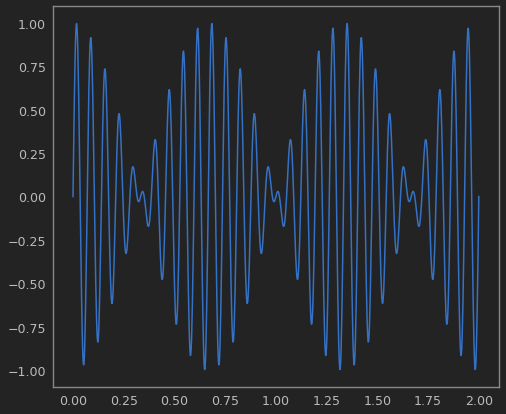

In [47]:
plt.plot(t, beat)